### Backtesting Study: Bollinger Band and RSI hybrid strategy - TSLA

In [15]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
from bokeh.util.warnings import BokehDeprecationWarning

warnings.filterwarnings('ignore', category=BokehDeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
path = 'stock_data/TSLA_stock_data.csv'
stock_data = pd.read_csv(path, parse_dates=True, index_col='Date')
stock_data = stock_data[stock_data.index >= '2022-01-01']

In [4]:
def rsi(array, window):
    deltas = np.diff(array)
    seed = deltas[:window+1]
    up = seed[seed >= 0].sum()/window
    down = -seed[seed < 0].sum()/window
    rs = up/down
    rsi = np.zeros_like(array)
    rsi[:window] = 100. - 100./(1. + rs)

    for i in range(window, len(array)):
        delta = deltas[i - 1]

        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(window - 1) + upval)/window
        down = (down*(window - 1) + downval)/window

        rs = up/down
        rsi[i] = 100. - 100./(1. + rs)

    return rsi

In [5]:
sma_period = 20
stock_data['SMA'] = stock_data['Close'].rolling(window=sma_period).mean()
stock_data['STD'] = stock_data['Close'].rolling(window=sma_period).std()
stock_data['Upper_Band'] = stock_data['SMA'] + (stock_data['STD'] * 2)
stock_data['Lower_Band'] = stock_data['SMA'] - (stock_data['STD'] * 2)

rsi_window = 14
stock_data['RSI'] = rsi(stock_data['Close'].to_numpy(), rsi_window)

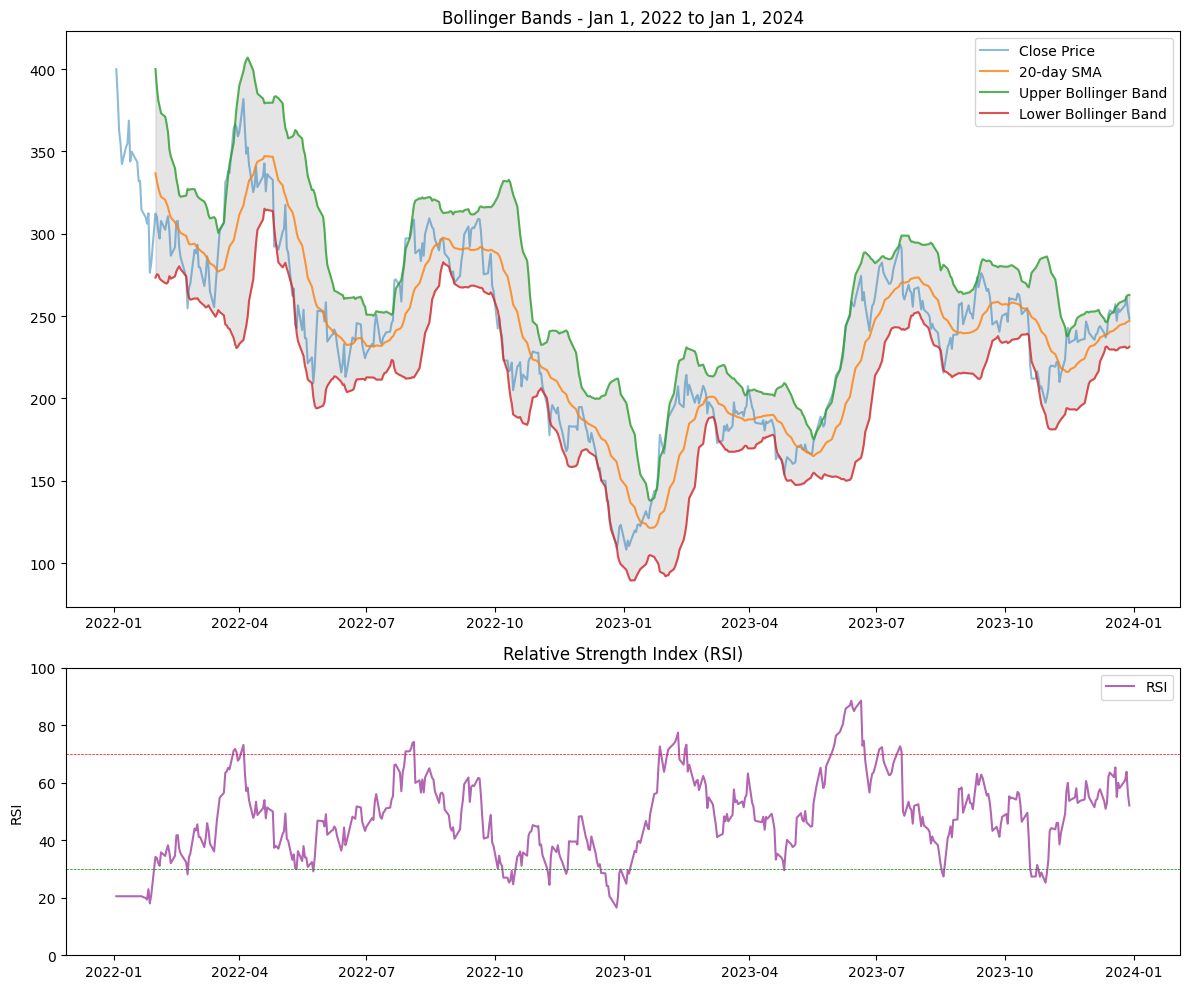

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]})

ax1.plot(stock_data['Close'], label='Close Price', alpha=0.5)
ax1.plot(stock_data['SMA'], label='20-day SMA', alpha=0.8)
ax1.plot(stock_data['Upper_Band'], label='Upper Bollinger Band', alpha=0.8)
ax1.plot(stock_data['Lower_Band'], label='Lower Bollinger Band', alpha=0.8)
ax1.fill_between(stock_data.index, stock_data['Upper_Band'], stock_data['Lower_Band'], color='grey', alpha=0.2)
ax1.set_title('Bollinger Bands - Jan 1, 2022 to Jan 1, 2024')
ax1.legend()

ax2.plot(stock_data['RSI'], label='RSI', color='purple', alpha=0.6)
ax2.axhline(70, color='red', linestyle='--', linewidth=0.5)  # Overbought line (70)
ax2.axhline(30, color='green', linestyle='--', linewidth=0.5)  # Oversold line (30)
ax2.set_ylim([0, 100])
ax2.set_ylabel('RSI')
ax2.set_title('Relative Strength Index (RSI)')
ax2.legend()

plt.tight_layout()
plt.show()

In [7]:
class BollingerRSIStrategy(Strategy):
    def init(self):
        self.upper_band = self.I(lambda x: x['Upper_Band'], self.data.df)
        self.lower_band = self.I(lambda x: x['Lower_Band'], self.data.df)
        self.rsi = self.I(lambda x: x['RSI'], self.data.df)

    def next(self):
        if crossover(self.data.Close, self.lower_band) and self.rsi[-1] < 30:
            self.buy()

        elif crossover(self.upper_band, self.data.Close) and self.rsi[-1] > 70:
            self.sell()

In [8]:
bt = Backtest(stock_data, BollingerRSIStrategy, cash=10000, commission=.002, exclusive_orders=True)
stats = bt.run()

print(stats)

bt.plot()

Start                     2022-01-03 00:00:00
End                       2023-12-29 00:00:00
Duration                    725 days 00:00:00
Exposure Time [%]                   88.023952
Equity Final [$]                 14417.496244
Equity Peak [$]                  18715.136108
Return [%]                          44.174962
Buy & Hold Return [%]               -37.86861
Return (Ann.) [%]                   20.204477
Volatility (Ann.) [%]               69.527542
Sharpe Ratio                         0.290597
Sortino Ratio                         0.55339
Calmar Ratio                         0.383212
Max. Drawdown [%]                  -52.723981
Avg. Drawdown [%]                   -7.558869
Max. Drawdown Duration      427 days 00:00:00
Avg. Drawdown Duration       33 days 00:00:00
# Trades                                   10
Win Rate [%]                             50.0
Best Trade [%]                      79.174835
Worst Trade [%]                    -34.031008
Avg. Trade [%]                    

GridPlot(id='p1371', ...)

In [9]:
sma_periods = range(5, 51, 5)  # For example, from 5 to 50 in steps of 5
std_dev_multipliers = [1, 2, 3]  # Standard deviation multipliers
rsi_windows = range(10, 21, 2)  # RSI window periods

best_sharpe = -float('inf')
best_params = {}

In [10]:
for sma_period in sma_periods:
    for std_dev_multiplier in std_dev_multipliers:
        for rsi_window in rsi_windows:
            # Calculate Bollinger Bands and RSI for the current set of parameters
            stock_data['SMA'] = stock_data['Close'].rolling(window=sma_period).mean()
            stock_data['STD'] = stock_data['Close'].rolling(window=sma_period).std()
            stock_data['Upper_Band'] = stock_data['SMA'] + (stock_data['STD'] * std_dev_multiplier)
            stock_data['Lower_Band'] = stock_data['SMA'] - (stock_data['STD'] * std_dev_multiplier)
            stock_data['RSI'] = rsi(stock_data['Close'].to_numpy(), rsi_window)

            # Run backtest
            bt = Backtest(stock_data, BollingerRSIStrategy, cash=10000, commission=.002)
            stats = bt.run()

            # Check if this combination has the best Sharpe ratio
            if stats['Sharpe Ratio'] > best_sharpe:
                best_sharpe = stats['Sharpe Ratio']
                best_params = {
                    'SMA Period': sma_period,
                    'Std Dev Multiplier': std_dev_multiplier,
                    'RSI Window': rsi_window,
                    'Sharpe Ratio': best_sharpe
                }


In [11]:
print("Best Parameters:")
print(f"SMA Period: {best_params['SMA Period']}")
print(f"Standard Deviation Multiplier: {best_params['Std Dev Multiplier']}")
print(f"RSI Window: {best_params['RSI Window']}")
print(f"Sharpe Ratio: {best_params['Sharpe Ratio']}")

Best Parameters:
SMA Period: 15
Standard Deviation Multiplier: 1
RSI Window: 12
Sharpe Ratio: 1.2193349025388511


In [12]:
stock_data['SMA'] = stock_data['Close'].rolling(window=best_params['SMA Period']).mean()
stock_data['STD'] = stock_data['Close'].rolling(window=best_params['SMA Period']).std()
stock_data['Upper_Band'] = stock_data['SMA'] + (stock_data['STD'] * best_params['Std Dev Multiplier'])
stock_data['Lower_Band'] = stock_data['SMA'] - (stock_data['STD'] * best_params['Std Dev Multiplier'])
stock_data['RSI'] = rsi(stock_data['Close'].to_numpy(), best_params['RSI Window'])

In [14]:
bt = Backtest(stock_data, BollingerRSIStrategy, cash=10000, commission=.002, exclusive_orders=True)
stats = bt.run()

print(stats)

bt.plot()

Start                     2022-01-03 00:00:00
End                       2023-12-29 00:00:00
Duration                    725 days 00:00:00
Exposure Time [%]                    87.42515
Equity Final [$]                 34271.302893
Equity Peak [$]                  42297.163657
Return [%]                         242.713029
Buy & Hold Return [%]               -37.86861
Return (Ann.) [%]                   85.809064
Volatility (Ann.) [%]                84.69901
Sharpe Ratio                         1.013106
Sortino Ratio                         3.15118
Calmar Ratio                         3.047898
Max. Drawdown [%]                  -28.153523
Avg. Drawdown [%]                   -6.942537
Max. Drawdown Duration      143 days 00:00:00
Avg. Drawdown Duration       23 days 00:00:00
# Trades                                    3
Win Rate [%]                        66.666667
Best Trade [%]                      111.25134
Worst Trade [%]                     -1.930544
Avg. Trade [%]                    

GridPlot(id='p1774', ...)